In [1]:
import torch
import numpy as np
from tqdm import tqdm
from torch_geometric.data import HeteroData
import os

In [2]:
from weight_datasets import PretrainedWeights, AdditiveNoise, SignFlip

In [3]:
weights_dataset = PretrainedWeights('datasets/PretrainedWeights/', transform=AdditiveNoise(0.3, 0.3))
weights_loader = torch.utils.data.DataLoader(weights_dataset, batch_size=50, shuffle=True)

In [4]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])
mnist = MNIST('./datasets', train=False, download=True, transform=transform)

valset = torch.utils.data.Subset(mnist, np.random.randint(0, len(mnist), 5000))
mnistloader = torch.utils.data.DataLoader(valset, batch_size=256, shuffle=True)

In [5]:
from mnist_cnn import MNIST_CNN

mnist_cnn = MNIST_CNN().to('cuda:0')

In [6]:
epochs = 200

In [7]:
num_aggr = 20

In [8]:
from fl_utils import fed_avg
from train_val import mnist_validation

In [9]:
stats = {'perturb': [], 'acc': []}

In [10]:
root = '/mnt/d/graph_dataset/raw/'

In [11]:
for epoch in range(epochs):
    pbar = tqdm(weights_loader)
    for weights, labels in pbar:
        weights_cuda = {k: w.cuda() for k, w in weights.items()}
        accs = []
        edges_rows = []
        edges_cols = []
        for aggr_idx in range(num_aggr):
            nums = np.random.randint(3, 8, 1)[0]
            selected_model_idx = np.sort(np.random.choice(50, size=nums, replace=False))
            edges_rows.append(selected_model_idx)
            edges_cols.append(np.full(nums, aggr_idx, dtype=selected_model_idx.dtype))
            selected_weights = {k: w[selected_model_idx, ...] for k, w in weights_cuda.items()}
            
            agg_weights = fed_avg(selected_weights)
            mnist_cnn.load_state_dict(agg_weights)
            acc = mnist_validation(mnistloader, mnist_cnn)
            accs.append(acc)
            
            perturb = 1 - labels[selected_model_idx].sum().item() / len(selected_model_idx)
            pbar.set_postfix({'acc': acc, 'perturb rate': perturb})
            stats['perturb'].append(perturb)
            stats['acc'].append(acc)
        
        edge_index = torch.vstack([torch.from_numpy(np.concatenate(edges_rows)),
                                   torch.from_numpy(np.concatenate(edges_cols)),])
        data = HeteroData(aggregator={'x': torch.tensor(accs)[:, None]},
                          clients__aggregator={'edge_index': edge_index},
                          aggregator__clients={'edge_index': edge_index[torch.tensor([1, 0])]},
                          y=labels)
        for k, w in weights.items():
            data[k].x = w
        
        cur_models = os.listdir(root)
        cur_models = len([m for m in cur_models if m.endswith('.pt')])
        torch.save(data, os.path.join(root, f'model{cur_models}.pt'))

100%|████████████████████████████████████████████████████████| 10/10 [01:37<00:00,  9.71s/it, acc=0.911, perturb rate=0]


In [12]:
# graphs = [data, data, data, data]

In [13]:
# from torch_geometric.loader import DataLoader

In [14]:
# loader = DataLoader(graphs, batch_size=2)

<AxesSubplot: xlabel='perturb', ylabel='acc'>

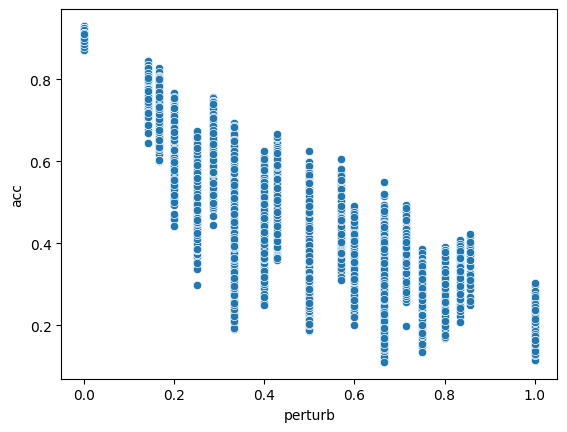

In [15]:
import seaborn as sns

sns.scatterplot(stats, x='perturb', y='acc')